In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("/content/combined_with_reviews.csv")

# Zorg dat review_text niet null is
df = df[df['review_text'].notnull()]
df['review_text'] = df['review_text'].fillna('')

# Groepeer per bedrijf (place_id)
grouped = df.groupby("place_id").agg({
    "review_text": lambda x: " ".join(x.dropna()),
    "review_rating": "mean",
    "author_reviews_count": "mean",
    "author_ratings_count": "mean",
    "fraud": "max"  # Neem het label van het bedrijf
}).reset_index()

# Optioneel: balanceren
df_fraud = grouped[grouped['fraud'] == 1]
df_nonfraud = grouped[grouped['fraud'] == 0]
n_samples = min(len(df_fraud), len(df_nonfraud))
df_balanced = pd.concat([
    df_fraud.sample(n=n_samples, random_state=42),
    df_nonfraud.sample(n=n_samples, random_state=42)
]).sample(frac=1, random_state=42).reset_index(drop=True)

<ipython-input-2-04b187c2ea23>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_text'] = df['review_text'].fillna('')


In [3]:
text_data = df_balanced["review_text"].tolist()
labels = df_balanced["fraud"].values

meta_cols = ['review_rating', 'author_reviews_count', 'author_ratings_count']
df_balanced[meta_cols] = df_balanced[meta_cols].fillna(0)
scaler = StandardScaler()
meta_features = scaler.fit_transform(df_balanced[meta_cols])

# Train/test-split
X_train_text, X_test_text, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    text_data, meta_features, labels, test_size=0.2, random_state=42, stratify=labels
)

In [4]:
class ReviewDataset(Dataset):
    def __init__(self, texts, metas, labels, tokenizer, max_len=128):
        self.texts = texts
        self.metas = metas
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'meta': torch.tensor(self.metas[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Model
class BERTFraudClassifier(nn.Module):
    def __init__(self, meta_input_size):
        super(BERTFraudClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc1 = nn.Linear(768 + meta_input_size, 128)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(128, 1)

    def forward(self, input_ids, attention_mask, meta):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        x = torch.cat((bert_output, meta), dim=1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.out(x)).squeeze(-1)

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = ReviewDataset(X_train_text, X_train_meta, y_train, tokenizer)
test_dataset = ReviewDataset(X_test_text, X_test_meta, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTFraudClassifier(meta_input_size=X_train_meta.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        meta = batch['meta'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, meta)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

Epoch 1 Loss: 0.5658
Epoch 2 Loss: 0.4278
Epoch 3 Loss: 0.4091


Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      1.00      0.83       117
         1.0       1.00      0.59      0.74       117

    accuracy                           0.79       234
   macro avg       0.85      0.79      0.79       234
weighted avg       0.85      0.79      0.79       234

ROC AUC: 0.8648549930601213


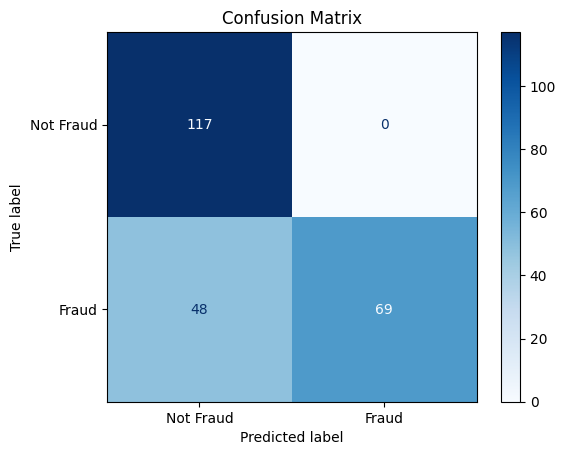

In [7]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        meta = batch['meta'].to(device)
        labels = batch['label'].cpu().numpy()
        outputs = model(input_ids, attention_mask, meta).cpu().numpy()
        all_preds.extend(outputs)
        all_labels.extend(labels)

preds_bin = [1 if p >= 0.5 else 0 for p in all_preds]
print("Classification Report:")
print(classification_report(all_labels, preds_bin))
print("ROC AUC:", roc_auc_score(all_labels, all_preds))

cm = confusion_matrix(all_labels, preds_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()